### Import Packages

In [1]:
import math
import heapq
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from deap import base, creator, tools, algorithms

warnings.filterwarnings('ignore')

### Read in Data

In [2]:
# read in csv as dataframe
raw_df = pd.read_csv('tr_eikon_eod_data.csv', parse_dates=True, index_col=0)
stocks = ['AAPL.O', 'MSFT.O', 'INTC.O', 'AMZN.O', 'GS.N']
data = raw_df[stocks]
data.ffill()

def train_test_split(df, ratio = 0.5):
    n = len(df)
    split = math.floor(n * ratio)
    
    return df[:split], df[split:]

# split into train and test set
train, test = train_test_split(data, 0.8)

In [3]:
train

,AAPL.O,MSFT.O,INTC.O,AMZN.O,GS.N
Date,,,,,
2010-01-01,NaN,NaN,NaN,NaN,NaN
2010-01-04,30.572827,30.950,20.88,133.90,173.08
2010-01-05,30.625684,30.960,20.87,134.69,176.14
2010-01-06,30.138541,30.770,20.80,132.25,174.26
2010-01-07,30.082827,30.452,20.60,130.00,177.67
...,...,...,...,...,...
2016-10-11,116.300000,57.190,37.27,831.00,169.04
2016-10-12,117.340000,57.110,37.13,834.09,169.30
2016-10-13,116.980000,56.920,36.97,829.28,167.42


In [4]:
# # Visualisation and exploration
# # dict to store fib ranges
# fib_ranges = {}
# ratios = [0, 0.236, 0.382, 0.5 , 0.618, 0.786,1]
# colors = ["black","r","g","b","cyan","magenta","yellow"]
# for stock in stocks:

#     levels = []
#     max_level = train[stock].max()
#     min_level = train[stock].min()
#     for ratio in ratios:
#         levels.append(min_level + (max_level-min_level)*ratio)
#     fib_ranges[stock] = levels
       
# fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 30))

# for i, stock in enumerate(stocks):  # Iterate through each stock with its index
#     axes[i].plot(train.index, train[stock], label=f'{stock} Closing Prices')  # Plot the closing prices for each stock
#     axes[i].set_title(f'Fibonacci Retracement Levels for {stock}')
    
#     for j, level in enumerate(fib_ranges[stock]):
#         # Correctly call axhlines on each subplot axis object
#         axes[i].axhline(level, label="{:.1f}%".format(ratios[j]*100), color=colors[j], linestyle="-")

#     axes[i].legend()

# plt.tight_layout()
# plt.show()


In [5]:
# # Visualisation and exploration
# # dict to store fib ranges
# fib_ranges = {}
# ratios = [0, 0.236, 0.382, 0.5 , 0.618, 0.786,1]
# colors = ["black","r","g","b","cyan","magenta","yellow"]
# for stock in stocks:

#     levels = []
#     max_level = test[stock].max()
#     min_level = test[stock].min()
#     for ratio in ratios:
#         levels.append(min_level + (max_level-min_level)*ratio)
#     fib_ranges[stock] = levels
       
# fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 30))

# for i, stock in enumerate(stocks):  # Iterate through each stock with its index
#     axes[i].plot(test.index, test[stock], label=f'{stock} Closing Prices')  # Plot the closing prices for each stock
#     axes[i].set_title(f'TEST Fibonacci Retracement Levels for {stock}')
    
#     for j, level in enumerate(fib_ranges[stock]):
#         # Correctly call axhlines on each subplot axis object
#         axes[i].axhline(level, label="{:.1f}%".format(ratios[j]*100), color=colors[j], linestyle="-")

#     axes[i].legend()

# plt.tight_layout()
# plt.show()


In [7]:
# PARAMETER TUNING
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# DataFrame for tracking trades
def calculate_fib_levels(max_price, min_price):
    ratios = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]
    return [min_price + (max_price - min_price) * ratio for ratio in ratios]

trades = pd.DataFrame(columns=['Stock', 'Buy Date', 'Buy Price', 'Sell Date', 'Sell Price'])


def fibonacci_retracement(window, sell_level):
    holding_stock = [False] * len(stocks)
    entry_price = [0] * len(stocks)
    next_level_up = [None] * len(stocks)
    # store trades
    trades = pd.DataFrame(columns=['Stock', 'Buy Date', 'Buy Price', 'Sell Date', 'Sell Price'])
    # Adjusting to use a rolling window for weekly high/low for Fibonacci level calculation
    for stock_num, stock in enumerate(stocks):
        for date, current_close in train[stock].items():
            recent_window = train[stock].loc[date - pd.Timedelta(days=window):date]
            max_price = recent_window.max()
            min_price = recent_window.min()
        
            # Recalculate Fib levels based on new max and min
            fib_levels = calculate_fib_levels(max_price, min_price)
            
            if not holding_stock[stock_num]:
                # Buy logic based on updated fib levels
                for i, level in enumerate(fib_levels[:-1]):  # Exclude the last level
                    if current_close < level:
                        holding_stock[stock_num] = True
                        entry_price[stock_num] = current_close
                        buy_date = date
                        next_level_up[stock_num] = fib_levels[i + sell_level] if i + sell_level < len(fib_levels) else None
                        break
            else:
                # Sell logic based on the next Fibonacci level up
                if next_level_up[stock_num] and current_close > next_level_up[stock_num]:
                    sell_price = current_close
                    sell_date = date
                    trades = pd.concat([trades, pd.DataFrame({
                        'Stock': stock,
                        'Buy Date': buy_date,
                        'Buy Price': entry_price[stock_num],
                        'Sell Date': sell_date,
                        'Sell Price': sell_price
                    }, index=[0])], ignore_index=True)
                    holding_stock[stock_num] = False  # Reset position
                    entry_price[stock_num] = 0
                    next_level_up[stock_num] = None

    # Ensure you exit any remaining positions at the end of the period
    for i, stock in enumerate(stocks):
        if holding_stock[i]:
            sell_date = train.index[-1]
            sell_price = train[stock].iloc[-1]
            trades = pd.concat([trades, pd.DataFrame({
                'Stock': stock,
                'Buy Date': buy_date,
                'Buy Price': entry_price[i],
                'Sell Date': sell_date,
                'Sell Price': sell_price
            }, index=[0])], ignore_index=True)
    total_return = (np.sum(trades['Sell Price']) / np.sum(trades['Buy Price'])) - 1
    strategy_return = total_return * 252 / len(train)

    return strategy_return



In [8]:
# Dont run this
best_window, best_level, best_return = None, None, 0
windows = range(1, 500)
levels = range(1, 6)
for w in windows:
    for l in levels:
        performance = fibonacci_retracement(w, l)
        if performance > best_return:
            best_window, best_level = w, l
            best_returns = performance
print("Best return is: ", best_return)
print("Best window size is: ", best_window)
print("Best profit taking level is: ", best_level)


KeyboardInterrupt: 

In [ ]:
data.dropna(inplace=True)
benchmark_returns = ((np.sum(test.iloc[-1]) / np.sum(test.iloc[0])) - 1) * 252 / len(test)
benchmark_returns

/var/folders/03/q00dbcxj1fjfrj0wgmvt85_h0000gn/T/ipykernel_41341/3656046195.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.dropna(inplace=True)


0.5563782968323068

In [14]:
data['MSFT.O']

Date
2010-01-04    30.950
2010-01-05    30.960
2010-01-06    30.770
2010-01-07    30.452
2010-01-08    30.660
               ...  
2018-06-25    98.390
2018-06-26    99.080
2018-06-27    97.540
2018-06-28    98.630
2018-06-29    98.610
Name: MSFT.O, Length: 2138, dtype: float64

In [309]:
# # DataFrame for tracking trades
# trades = pd.DataFrame(columns=['Stock', 'Buy Date', 'Buy Price', 'Sell Date', 'Sell Price'])

# def calculate_fib_levels(max_price, min_price):
#     ratios = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]
#     return [min_price + (max_price - min_price) * ratio for ratio in ratios]

# holding_stock = [False] * 5
# entry_price = [0] * 5
# for stock_num, stock in enumerate(stocks):
#     max_price = train[stock].max()
#     min_price = train[stock].min()
#     fib_levels = calculate_fib_levels(max_price, min_price)

#     for date, current_close in test[stock].items():
#         # Update Fibonacci levels if new high or low is observed
#         if current_close > max_price:
#             max_price = current_close
#             fib_levels = calculate_fib_levels(max_price, min_price)
#         elif current_close < min_price:
#             min_price = current_close
#             fib_levels = calculate_fib_levels(max_price, min_price)
            
#         if not holding_stock[stock_num]:
#             # Buy logic based on updated fib levels
#             for i, level in enumerate(fib_levels[:-1]):  # Exclude the last level
#                 if current_close < level:
#                     holding_stock[stock_num] = True
#                     entry_price[stock_num] = current_close
#                     buy_date = date
#                     next_level_up = fib_levels[i + 1] if i + 1 < len(fib_levels) else None
#                     break
#         else:
#             # Sell logic based on the next Fibonacci level up
#             if next_level_up and current_close > next_level_up:
#                 sell_price = current_close
#                 sell_date = date
#                 trades = pd.concat([trades, pd.DataFrame({
#                     'Stock': stock,
#                     'Buy Date': buy_date,
#                     'Buy Price': entry_price[stock_num],
#                     'Sell Date': sell_date,
#                     'Sell Price': sell_price
#                 }, index=[0])], ignore_index=True)
#                 holding_stock[stock_num] = False  # Reset position
#                 entry_price[stock_num] = 0

# # Ensure you exit any remaining positions at the end of the period
# for i, stock in enumerate(stocks):
#     if holding_stock[i]:
#         sell_date = test.index[-1]
#         sell_price = test[stock].iloc[-1]
#         trades = pd.concat([trades, pd.DataFrame({
#             'Stock': stock,
#             'Buy Date': buy_date,
#             'Buy Price': entry_price[i],
#             'Sell Date': sell_date,
#             'Sell Price': sell_price
#         }, index=[0])], ignore_index=True)

# print(trades)


In [310]:

# DataFrame for tracking trades
trades = pd.DataFrame(columns=['Stock', 'Buy Date', 'Buy Price', 'Sell Date', 'Sell Price'])

def calculate_fib_levels(max_price, min_price):
    ratios = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]
    return [min_price + (max_price - min_price) * ratio for ratio in ratios]

holding_stock = [False] * len(stocks)
entry_price = [0] * len(stocks)
next_level_up = [None] * len(stocks)

# Adjusting to use a rolling window for weekly high/low for Fibonacci level calculation
for stock_num, stock in enumerate(stocks):
    for date, current_close in test[stock].items():
        recent_window = test[stock].loc[date - pd.Timedelta(days=499):date]
        max_price = recent_window.max()
        min_price = recent_window.min()
    
        # Recalculate Fib levels based on new max and min
        fib_levels = calculate_fib_levels(max_price, min_price)
        
        if not holding_stock[stock_num]:
            # Buy logic based on updated fib levels
            for i, level in enumerate(fib_levels[:-1]):  # Exclude the last level
                if current_close < level:
                    holding_stock[stock_num] = True
                    entry_price[stock_num] = current_close
                    buy_date = date
                    next_level_up[stock_num] = fib_levels[i + 3] if i + 3 < len(fib_levels) else None
                    break
        else:
            # Sell logic based on the next Fibonacci level up
            if next_level_up[stock_num] and current_close > next_level_up[stock_num]:
                sell_price = current_close
                sell_date = date
                trades = pd.concat([trades, pd.DataFrame({
                    'Stock': stock,
                    'Buy Date': buy_date,
                    'Buy Price': entry_price[stock_num],
                    'Sell Date': sell_date,
                    'Sell Price': sell_price
                }, index=[0])], ignore_index=True)
                holding_stock[stock_num] = False  # Reset position
                entry_price[stock_num] = 0
                next_level_up[stock_num] = None

# Ensure you exit any remaining positions at the end of the period
for i, stock in enumerate(stocks):
    if holding_stock[i]:
        sell_date = test.index[-1]
        sell_price = test[stock].iloc[-1]
        trades = pd.concat([trades, pd.DataFrame({
            'Stock': stock,
            'Buy Date': buy_date,
            'Buy Price': entry_price[i],
            'Sell Date': sell_date,
            'Sell Price': sell_price
        }, index=[0])], ignore_index=True)
total_return = (np.sum(trades['Sell Price']) / np.sum(trades['Buy Price'])) - 1
strategy_return = total_return * 252 / len(test)
print(trades)
print(strategy_return)

     Stock   Buy Date  Buy Price  Sell Date  Sell Price
0   AAPL.O 2016-10-19     117.12 2016-10-24      117.65
1   AAPL.O 2016-10-26     115.59 2016-12-27      117.26
2   MSFT.O 2016-10-19      57.53 2016-10-21       59.66
3   INTC.O 2016-10-19      35.51 2016-12-20       37.21
4   AMZN.O 2016-10-20     810.32 2016-10-21      818.99
5   AMZN.O 2016-10-26     822.59 2017-01-26      839.15
6   AAPL.O 2016-11-02     145.16 2018-06-29      185.11
7   MSFT.O 2016-11-02      60.10 2018-06-29       98.61
8   INTC.O 2016-11-02      36.63 2018-06-29       49.71
9   AMZN.O 2016-11-02     810.20 2018-06-29     1699.80
10    GS.N 2016-11-02     176.58 2018-06-29      220.57
0.18811127266480163


In [311]:
# trades = pd.DataFrame(columns=['Stock', 'Buy Date', 'Buy Price', 'Sell Date', 'Sell Price'])

# for stock in stocks:
#     in_position = False
#     buy_price = None
#     buy_date = None
#     sell_price = None
#     sell_date = None
#     next_level_up = None

#     for date, current_close in test[stock].items():
#         if not in_position:
#             # Check if current close crossed any Fib level downwards
#             for i, level in enumerate(fib_ranges[stock][:-1]):  # Exclude the last level to ensure a next level exists
#                 if current_close < level and not in_position:
#                     # This simulates a buy signal
#                     in_position = True
#                     buy_price = current_close
#                     buy_date = date
#                     next_level_up = fib_ranges[stock][i + 1]  # Next Fibonacci level for the sell condition
#                     break  # Break after entering position
#         else:
#             # Check if current close is above the next Fibonacci level to sell
#             if current_close > next_level_up:
#                 sell_price = current_close
#                 sell_date = date
#                 trades = pd.concat([trades, pd.DataFrame({
#                     'Stock': stock, 
#                     'Buy Date': buy_date, 
#                     'Buy Price': buy_price, 
#                     'Sell Date': sell_date, 
#                     'Sell Price': sell_price
#                 }, index=[0])], ignore_index=True)
#                 in_position = False  # Reset position

# # Ensure you exit any remaining positions at the end of the period
# for stock in stocks:
#     if in_position:
#         # Assuming we close the position on the last available date at the last available price
#         sell_date = test.index[-1]
#         sell_price = test[stock].iloc[-1]
#         trades = pd.concat([trades, pd.DataFrame({
#             'Stock': stock, 
#             'Buy Date': buy_date, 
#             'Buy Price': buy_price, 
#             'Sell Date': sell_date, 
#             'Sell Price': sell_price
#         }, index=[0])], ignore_index=True)
# trades

In [312]:
total_return = (np.sum(trades['Sell Price']) / np.sum(trades['Buy Price'])) - 1
strategy_return = total_return * 252 / len(test)
strategy_return

0.18811127266480163

## Justin's Code

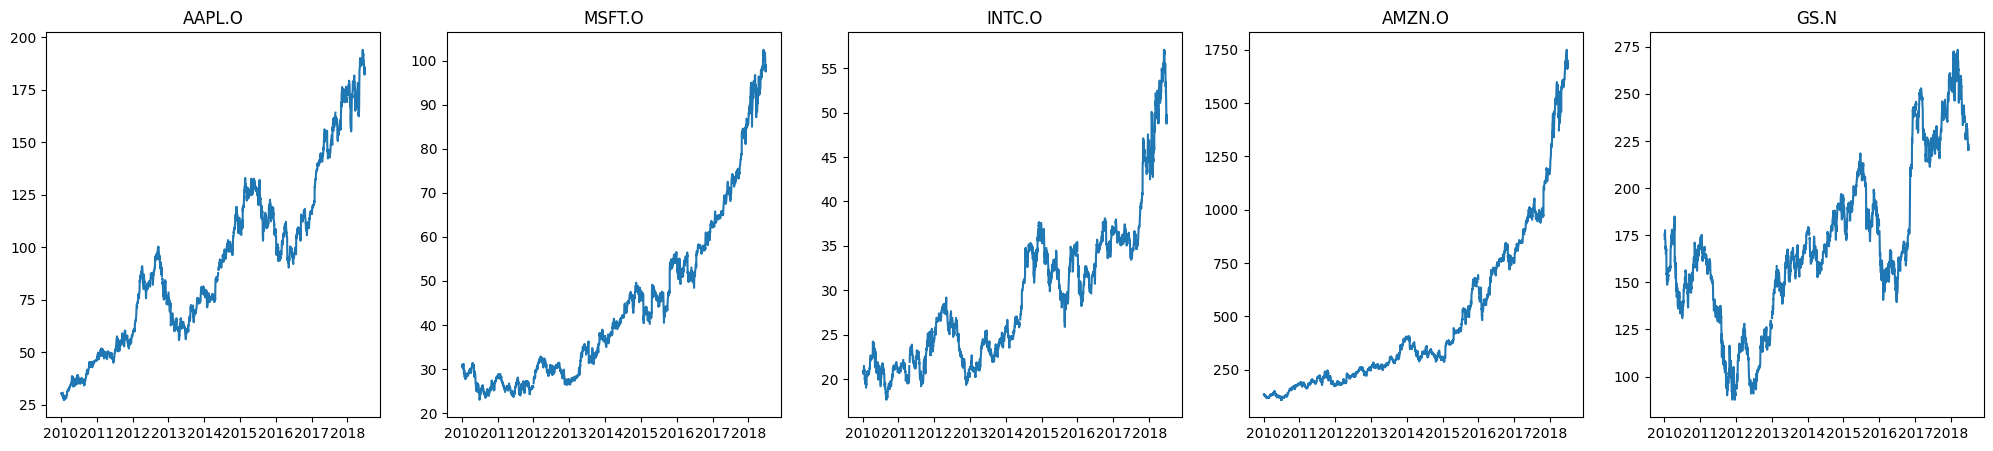

In [3]:
_, axes = plt.subplots(1, 5, figsize=(25,5))
for index, stock in enumerate(stocks):
    axes[index].plot(data[stock])
    axes[index].set_title(stock)

#### 1. Strategy Creation

In [99]:
def calculate_fib_levels(max_price, min_price):
    ratios = [0, 0.236, 0.382, 0.5, 0.618, 0.786, 1]
    return [min_price + (max_price - min_price) * ratio for ratio in ratios]

def fibonacci_retracement(stock, window, exit_level):
    levels = ['level_1', 'level_2', 'level_3', 'level_4', 'level_5', 'level_6', 'level_7']
    stock = pd.DataFrame({"close": stock.copy().ffill()})
    stock["lag_1"] = stock.close.shift(1)
    
    stock["rolling_max"] = stock["close"].rolling(window).max().ffill()
    stock["rolling_min"] = stock["close"].rolling(window).min().ffill()
    
    result_array = stock.apply(lambda row: calculate_fib_levels(row["rolling_max"], row["rolling_min"]), axis=1)
    result_df = pd.DataFrame(result_array.tolist(), columns=levels).set_index(stock.index)
    stock = pd.concat([stock, result_df], axis=1)
    
    # Get entry
    temp_stock = stock.copy()
    name_crossups = ["level_1_crossup", "level_2_crossup", "level_3_crossup", "level_4_crossup", "level_5_crossup", "level_6_crossup", "level_7_crossup"]
    for index, level in enumerate(levels):
        signal_buy = (temp_stock.lag_1 < temp_stock[level]) & (temp_stock.close > temp_stock[level])
        temp_stock.loc[signal_buy, name_crossups[index]] = temp_stock[level]

    # Process exit
    heap = []
    stock["position"] = 0
    for index, row in temp_stock.iterrows():
        entry_signal_price = row[name_crossups].min()
        
        while len(heap) > 0 and row.close >= heap[0][0]:
            target_exit_price, target_index = heapq.heappop(heap)
            stock.loc[target_index, "exit_index"] = index
            stock.loc[target_index, "exit_price"] = row.close
            stock.loc[target_index, "pnl"] = row.close - target_exit_price
            stock.loc[index, "position"] -= 1
        
        if entry_signal_price > 0:
            target_level_prices = list(filter(lambda x: x > entry_signal_price, row[levels]))
            target_exit_price = target_level_prices[min(exit_level - 1, len(target_level_prices) - 1)]
            heapq.heappush(heap, (target_exit_price, index))
            stock.loc[index, "entry_price"] = entry_signal_price
            stock.loc[index, "position"] += 1
    
    while len(heap) > 0:
        target_exit_price, target_index = heapq.heappop(heap)
        stock.loc[target_index, "exit_index"] = index
        stock.loc[target_index, "exit_price"] = stock.close[-1]
        stock.loc[target_index, "pnl"] = stock.close[-1] - target_exit_price
        stock.loc[index, "position"] -= 1

    # Calculate average position price
    prev_avg_cost = 0
    prev_position = 0
    stock["avg_cost"] = 0
    acc_position = 0
    for row in stock[["entry_price", "position"]].iterrows():
        index, items = row
        position = items["position"]
        entry_price = items["entry_price"]
        acc_position += position
        
        if acc_position > prev_position:
            prev_avg_cost = ((prev_position * prev_avg_cost) + (position * entry_price)) / acc_position
            prev_position = acc_position
            stock.loc[index, "avg_cost"] = prev_avg_cost
        elif acc_position < prev_position:
            prev_position = acc_position
            stock.loc[index, "avg_cost"] = prev_avg_cost
        elif acc_position == 0:
            prev_avg_cost = 0
            prev_position = 0
    
    return stock

    

#### 2. Strategy Visualisation

In this section, we will analyse the raw performance of our strategy with default settings. 

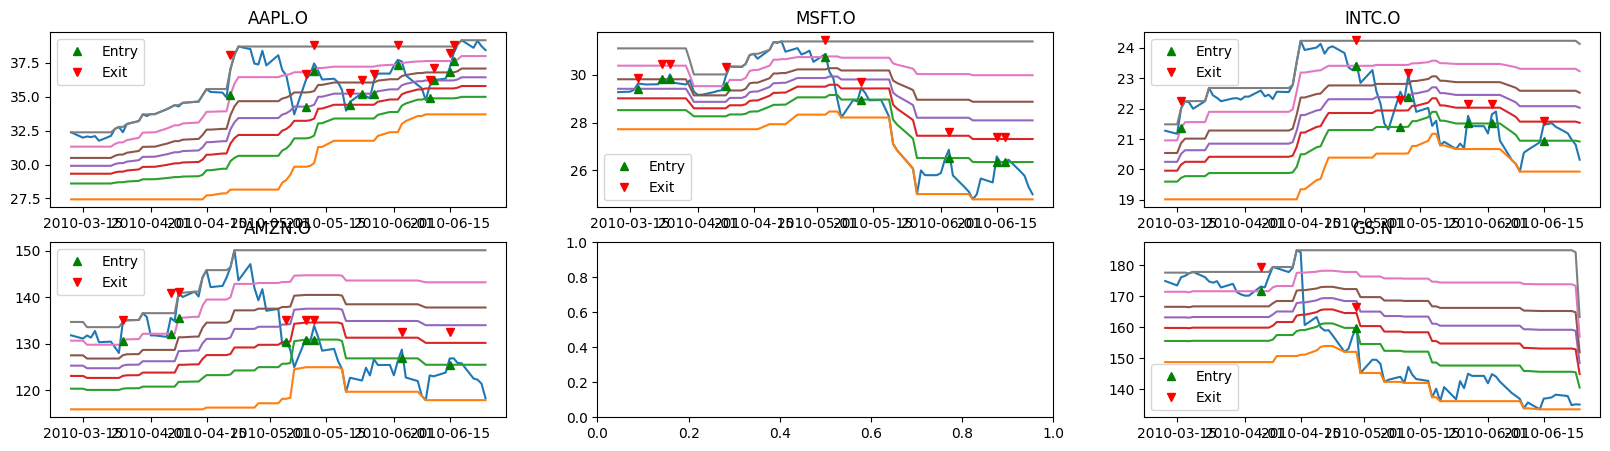

In [5]:
exit_level = 1 # The level step for the order to exit
window_lookback = 50
win_obsrv_start, win_obsrv_end = 50, 125

_, ax = plt.subplots(2, 3, figsize=(20, 5))
ax1, ax2, ax3 = ax[0]
ax4, ax5, ax6 = ax[1]
axes = [ax1, ax2, ax3, ax4, ax6]

def plot(name, df, ax):
    ax.plot(df.close)
    ax.plot(df.level_1)
    ax.plot(df.level_2)
    ax.plot(df.level_3)
    ax.plot(df.level_4)
    ax.plot(df.level_5)
    ax.plot(df.level_6)
    ax.plot(df.level_7)
    ax.plot(df.entry_price, "g^", label="Entry")
    ax.plot(df.exit_price, "rv", label="Exit")
    ax.set_title(name)
    ax.legend()
    
for index, stock in enumerate(stocks):
    result_fib_retrace = fibonacci_retracement(train[stock], window_lookback, exit_level)
    plot(stock, result_fib_retrace[win_obsrv_start: win_obsrv_end], axes[index])

plt.show()

#### 2. Strategy Performance Evaluation

In [114]:
def plot_pnl(df):
    return df.pnl.cumsum().ffill()[-1]
    
def cal_total_pnl(df):
    hasPosition = df.avg_cost > 0
    unrealised = df.close[hasPosition] - df.avg_cost[hasPosition]
    realised = df.pnl.cumsum().ffill()
    total_pnl = realised + unrealised
    return total_pnl
    
def cal_max_drawdown(df):
    return ((df - df.cummax()) / df.cummax()).min()

def cal_sharpe_ratio(df):
    return df.mean() / df.std()

def performance_mertic(df_result):
    total_pnl = cal_total_pnl(df_result)
    number_of_trades = df_result.entry_price.count()
    max_drawdown = cal_max_drawdown(total_pnl.ffill()) * 100
    sharpe_ratio = cal_sharpe_ratio(total_pnl)
    market_pnl = df_result.close.diff().cumsum().ffill()[-1]
    market_drawdown = cal_max_drawdown(df_result.close.diff().cumsum().ffill())
    print(f"{stock}\nTotal PnL: {total_pnl.ffill()[-1]}\nNumber of Trades: {number_of_trades}\nMax Drawdown: {max_drawdown}\nSharpe Ratio {sharpe_ratio}\nMarket PnL: {market_pnl}\nMarket Drawdown: {market_drawdown}\n")

for index, stock in enumerate(stocks):
    result_fib_retrace = fibonacci_retracement(train[stock], window_lookback, exit_level)
    print("Train")
    performance_mertic(result_fib_retrace)
    
    print("Test")
    result_fib_retrace = fibonacci_retracement(test[stock], window_lookback, exit_level)
    performance_mertic(result_fib_retrace)

Train
AAPL.O
Total PnL: 352.98194905038224
Number of Trades: 624
Max Drawdown: -33.86845645056764
Sharpe Ratio 1.4988180089672525
Market PnL: 86.97717343
Market Drawdown: -22.837837837836386

Test
AAPL.O
Total PnL: 195.98706000000013
Number of Trades: 156
Max Drawdown: -197.8180716017683
Sharpe Ratio 1.4078325901418702
Market PnL: 67.64000000000001
Market Drawdown: -16.076923076923062

Train
MSFT.O
Total PnL: 191.9108539668367
Number of Trades: 598
Max Drawdown: -89.03655110378526
Sharpe Ratio 1.3700965476559406
Market PnL: 26.27
Market Drawdown: -88.99999999998614

Test
MSFT.O
Total PnL: 66.46783750000007
Number of Trades: 161
Max Drawdown: -61.36652208802806
Sharpe Ratio 1.4089191983779759
Market PnL: 40.95
Market Drawdown: -0.8622754491017963

Train
INTC.O
Total PnL: 148.38359999999994
Number of Trades: 620
Max Drawdown: -29.812681086179865
Sharpe Ratio 1.6505745682231296
Market PnL: 16.41
Market Drawdown: -4.885714285714248

Test
INTC.O
Total PnL: 22.09330799999998
Number of Trades

#### 3. Strategy Optimisation

In [101]:
def fitness(df, window_lookback, exit_level):
    result_fib_retrace = fibonacci_retracement(df, window_lookback, exit_level)
    total_pnl = cal_total_pnl(result_fib_retrace)
    max_drawdown = cal_max_drawdown(total_pnl.ffill()) * 100
    sharpe_ratio = cal_sharpe_ratio(total_pnl)

    return total_pnl.ffill()[-1] #+ max_drawdown + sharpe_ratio

# Define the genetic algorithm
def genetic_algorithm(df, params_constraint, population_n=1, generations_n = 10, include_genome=[]):
    # Initialize the population with random values within the parameter range
    population = [{'window_lookback': random.randint(params_constraint['window_lookback'][0], params_constraint['window_lookback'][1]),
                   'exit_level': random.randint(params_constraint['exit_level'][0], params_constraint['exit_level'][1])}
                  for _ in range(population_n)]

    # Evolution loop
    for _ in range(generations_n):
        # Evaluate the fitness of each individual in the population
        fitness_scores = [(individual, fitness(df, individual['window_lookback'], individual['exit_level'])) for individual in population]

        # Sort the population by fitness score
        fitness_scores.sort(key=lambda x: x[1], reverse=True)

        # Select the top individuals to be parents for the next generation
        parents = [individual[0] for individual in fitness_scores[:population_n // 2]]
        # Create the next generation by crossover and mutation
        next_generation = []
        while len(next_generation) < population_n:
            parent1 = random.choice(parents)
            parent2 = random.choice(parents)

            # Crossover
            child = {'window_lookback': (parent1['window_lookback'] + parent2['window_lookback']) / 2,
                     'exit_level': (parent1['exit_level'] + parent2['exit_level']) / 2}

            # Mutation
            child['window_lookback'] = random.randint(params_constraint['window_lookback'][0], params_constraint['window_lookback'][1])
            child['exit_level'] = random.randint(params_constraint['exit_level'][0], params_constraint['exit_level'][1])

            # Ensure parameters are within range
            child['window_lookback'] = min(max(params_constraint['window_lookback'][0], child['window_lookback']), params_constraint['window_lookback'][1])
            child['exit_level'] = min(max(params_constraint['exit_level'][0], child['exit_level']), params_constraint['exit_level'][1])

            next_generation.append(child)

        population = next_generation

    # Return the best individual
    return population[0]

def walk_forward_optimisation(data, params_constraint, windows_n=5, train_test_ratio = 0.5, population_n=10):
    n = len(data)
    window_size = n // windows_n
    
    include_genome = []
    optimized_params = []
    i = 0
    while i < windows_n:
        train, test = train_test_split(data[:i + window_size], train_test_ratio)
        # try:
        optimized_params = genetic_algorithm(train.copy(), params_constraint=params_constraint, population_n=population_n, include_genome=include_genome)
        # except:
        #     continue
        
        include_genome = [optimized_params]
        i += 1
    
    return optimized_params

============ AAPL.O ============
Train optimised
AAPL.O
Total PnL: 160.63486761349355
Number of Trades: 419
Max Drawdown: -69.309723259125
Sharpe Ratio 1.4980018862450475
Market PnL: 86.97717343
Market Drawdown: -22.837837837836386

Test Results
AAPL.O
Total PnL: 116.90003000000004
Number of Trades: 102
Max Drawdown: -58.00012194378389
Sharpe Ratio 1.5596531328439727
Market PnL: 67.64000000000001
Market Drawdown: -16.076923076923062

Best Parameters
Window Lookback: 13 
Exit Level: 6



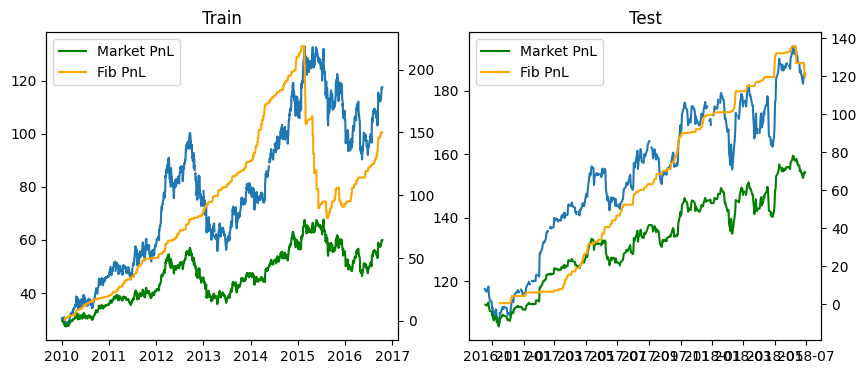

============ MSFT.O ============
Train optimised
MSFT.O
Total PnL: 161.4544786
Number of Trades: 428
Max Drawdown: -501.60103851148324
Sharpe Ratio 1.3842548982890592
Market PnL: 26.27
Market Drawdown: -88.99999999998614

Test Results
MSFT.O
Total PnL: 44.716090000000015
Number of Trades: 118
Max Drawdown: -44.97104440928179
Sharpe Ratio 1.515246167417343
Market PnL: 40.95
Market Drawdown: -0.8622754491017963

Best Parameters
Window Lookback: 15 
Exit Level: 3



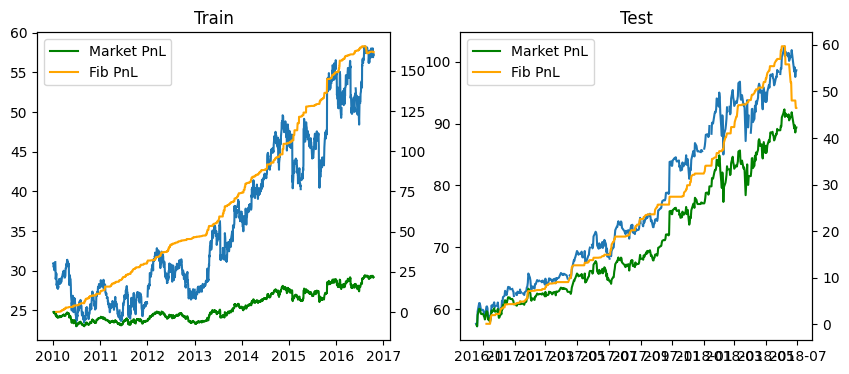

============ INTC.O ============
Train optimised
INTC.O
Total PnL: 109.57656920000007
Number of Trades: 443
Max Drawdown: -140.97337770382632
Sharpe Ratio 1.6440994019430535
Market PnL: 16.41
Market Drawdown: -4.885714285714248

Test Results
INTC.O
Total PnL: 19.663900000000005
Number of Trades: 101
Max Drawdown: -81.20343166059402
Sharpe Ratio 1.1627907284675492
Market PnL: 11.96
Market Drawdown: -19.65217391304373

Best Parameters
Window Lookback: 12 
Exit Level: 3



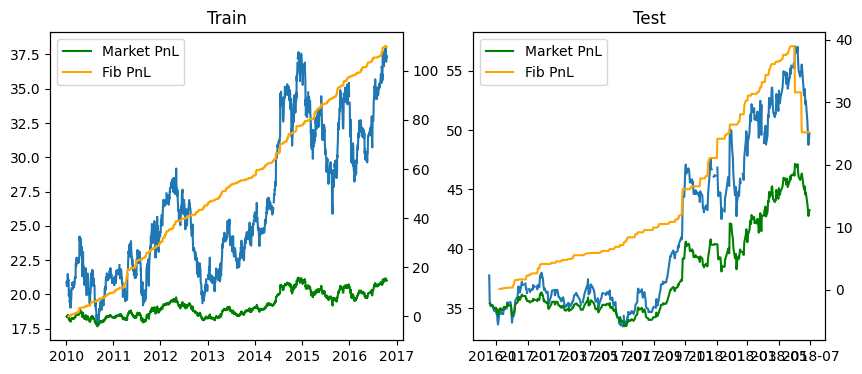

============ AMZN.O ============
Train optimised
AMZN.O
Total PnL: 3459.3662916000003
Number of Trades: 633
Max Drawdown: -69.86102053671888
Sharpe Ratio 1.347099905895911
Market PnL: 679.0500000000001
Market Drawdown: -23.734177215190112

Test Results
AMZN.O
Total PnL: 2510.492260000001
Number of Trades: 177
Max Drawdown: -18.656542508736994
Sharpe Ratio 1.2490814816509344
Market PnL: 882.15
Market Drawdown: -184.24999999964402

Best Parameters
Window Lookback: 5 
Exit Level: 1



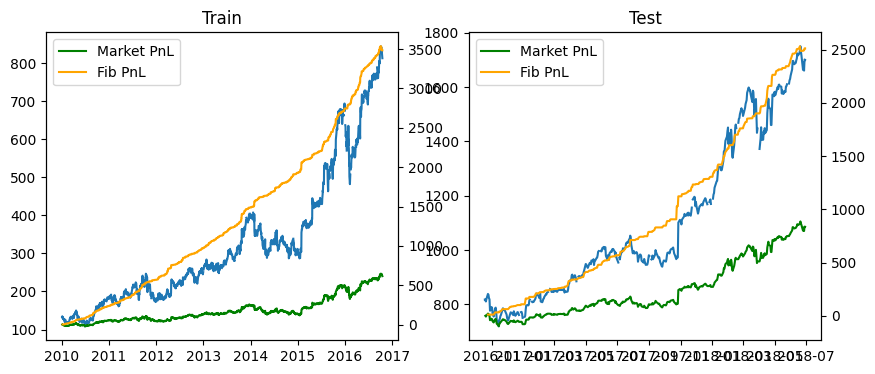

============ GS.N ============
Train optimised
GS.N
Total PnL: 695.1844795865704
Number of Trades: 553
Max Drawdown: -35.35173508779345
Sharpe Ratio 2.0514444514190653
Market PnL: -4.0800000000000125
Market Drawdown: -8.211148648648665

Test Results
GS.N
Total PnL: 233.2260553703704
Number of Trades: 137
Max Drawdown: -36.87521207645306
Sharpe Ratio 2.011429731777383
Market PnL: 47.94
Market Drawdown: -0.5280397022332505

Best Parameters
Window Lookback: 7 
Exit Level: 1



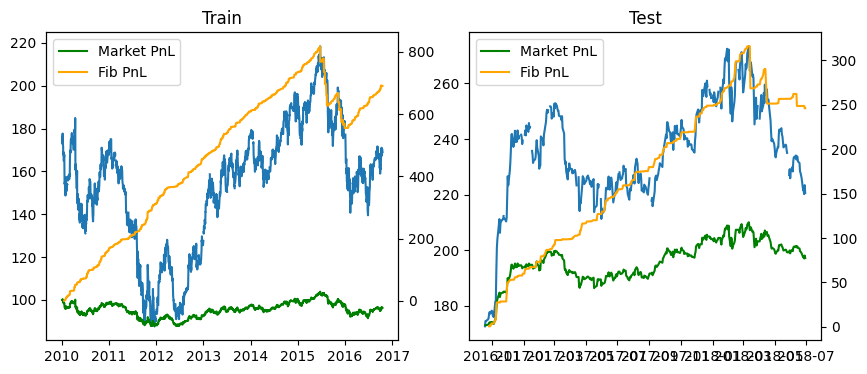

In [119]:
params_constraint = {
    "window_lookback": (5, 20),
    "exit_level": (0, 7)
}

for index, stock in enumerate(stocks):
    print("============", stock, "============")
    _, axes = plt.subplots(1, 2, figsize=(10,4))
    ax1, ax2 = axes

    optimised_params = walk_forward_optimisation(train[stock].copy(), params_constraint=params_constraint, train_test_ratio=0.8, population_n=10)
    window_lookback, exit_level = optimised_params["window_lookback"], optimised_params["exit_level"]

    print("Train optimised")
    result = fibonacci_retracement(train[stock], window_lookback, exit_level)
    performance_mertic(result)

    ax1.plot(train[stock])
    ax1_twin = ax1.twinx()
    ax1_twin.plot(train[stock].index, train[stock].diff().cumsum().ffill(), color="green", label="Market PnL") # Plot Pnl
    ax1_twin.plot(train[stock].index, result.pnl.cumsum().ffill(), color="orange", label="Fib PnL") # Plot Pnl
    ax1.set_title("Train")
    plt.legend()
    
    print("Test Results")
    result = fibonacci_retracement(test[stock], window_lookback, exit_level)
    performance_mertic(result)
    
    ax2.plot(test[stock])
    ax2_twin = ax2.twinx()
    ax2_twin.plot(test[stock].index, test[stock].diff().cumsum().ffill(), color="green", label="Market PnL") # Plot Pnl
    ax2_twin.plot(test[stock].index, result.pnl.cumsum().ffill(), color="orange", label="Fib PnL") # Plot Pnl
    ax2.set_title("Test")
    print(f"Best Parameters\nWindow Lookback: {window_lookback} \nExit Level: {exit_level}\n")
    plt.legend()
    plt.show()